# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# Reading feature types

In [2]:
feature_type = open('./data/public_data_1/mimic_synthetic_feat.type')
result = feature_type.readlines()
result = [i.replace("\n","") for i in result]
freq_features_type = Counter(result)
print(freq_features_type)

Counter({'Numerical': 226, 'Binary': 107, 'Categorical': 8})


# Reading feature in dataset

In [3]:
feature_data = open('./data/public_data_1/mimic_synthetic_feat.name')
result = feature_data.readlines()
result = [i.replace("\n","") for i in result]
print(result[:10])

['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER']


# Reading training data

In [4]:
names = pd.read_table('./data/public_data_1/mimic_synthetic_feat.name',sep='\n',header=None)
data = pd.read_table('./data/public_data_1/mimic_synthetic_train.data',sep=' ',header=None, index_col=0)
died = pd.read_table('./data/public_data_1/mimic_synthetic_train.solution',sep='\n',header=None)
test = pd.read_table('./data/public_data_1/mimic_synthetic_test.data' ,sep=' ' ,header=None, index_col=0)

# Assigning feature names to training Data

In [5]:
name_col = names[0].tolist() 
data.columns = name_col
test.columns = name_col

# Distribution of classes in Target variable

E:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


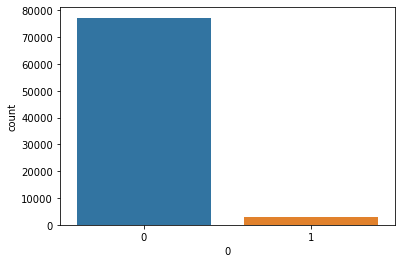

In [6]:
sns.countplot(died[0])

In [7]:
died[0].value_counts()

0    77202
1     2797
Name: 0, dtype: int64

# Percentage of Missing values

In [8]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name':data.columns,
                                 'percent_missing':percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df.to_csv('missing_values.csv')

In [9]:
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])
num_cols = list(numeric_data.columns)
cat_cols = list(categorical_data.columns)


In [10]:
print(cat_cols)

['ADMITTIME', 'DISCHTIME', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'ICU']


# Filling missing values in categorical columns with mode

In [11]:
data['ICU'] = data['ICU'].fillna('MICU')

# Filling missing values in numerical columns with Mean

In [12]:
data['Othnervdx'] = data['Othnervdx'].fillna(value=data['Othnervdx'].mean())
data['ECodes:Adverseeffectsofmedicalcare'] = data['ECodes:Adverseeffectsofmedicalcare'].fillna(value=data['ECodes:Adverseeffectsofmedicalcare'].mean())
data['Otnutritdx'] = data['Otnutritdx'].fillna(value=data['Otnutritdx'].mean())


In [13]:
data.shape

(79999, 341)

# Dropping unnecessary columns

In [14]:
data_final = data.drop(['SUBJECT_ID', 'HADM_ID','ADMITTIME','DISCHTIME', 'LANGUAGE', 'RELIGION','ETHNICITY','GENDER','MARITAL_STATUS','INSURANCE'], axis=1)

In [15]:
data_final.shape

(79999, 331)

# Checking constant features

In [16]:
column_list = list(data_final.columns)
constant_feature_list = []
for col in column_list:
    if len(dict(data_final[col].value_counts())) == 1:
        constant_feature_list.append(col)
                
print(len(constant_feature_list))

173


# Dropping constant features

In [17]:
data_processed = data_final.drop(constant_feature_list, axis=1)
data_processed.shape

(79999, 158)

# Checking Quasi constant feature

In [18]:
constant_features = get_constant_features(data_processed, threshold=0.99)
quasi_features = constant_features["Var"].tolist()
print(quasi_features)

['Glaucoma', 'Gastritis', 'Othereyedx', 'Otdxstomch', 'Retinaldx', 'Precereoccl', 'Cardiacanom', 'Gasduoulcer', 'Fxleg', 'Peritonitis', 'Otjointdx', 'Allergy', 'LateeffCVD', 'Breastcancr', 'Osteoarthros', 'Abdomhernia', 'Coma/brndmg', 'Fxarm', 'Otbnignneo', 'Prostatecan', 'Diverticulos', 'Opnwndhead', 'OtheredCNS', 'Brnch/lngca', 'Pancreasdx', 'Skininfectn', 'Whtblooddx', 'Otendodsor', 'Osteoporosis', 'Paralysis', 'Intestinfct', 'Intobstruct', 'Otdxkidney', 'BPH', 'Cardiaarrst', 'Anxietydisorders', 'ECodes:Placeofoccurrence', 'Mycoses', 'Gout/otcrys', 'Backproblem', 'Otupprresp', 'Substance-relateddisorders', 'Aneurysm', 'Biliarydx', 'Asthma', 'Nutritdefic', 'Hepatitis', 'Peripathero', 'Othlowresp', 'Epilepsy/cnv', 'Pulmhartdx', 'OtherGUdx', 'Ulcerskin', 'Carditis', 'ecodes:motorvehicletraffic(mvt)', 'Conduction']


# Dropping Quasi constant feature

In [19]:
data_processed_final =  data_processed.drop(quasi_features, axis=1)

In [20]:
data_processed_final.shape

(79999, 102)

In [21]:
data_processed_final["ICU"].value_counts()

MICU     27782
CSRU     16789
SICU     12803
CCU      11770
TSICU    10855
Name: ICU, dtype: int64

In [22]:
data_processed_final['ICU'] = data_processed_final['ICU'].map({'MICU': 0, 'CSRU': 1, 'SICU':2, 'CCU':3, 'TSICU':4})

In [23]:
data_processed_final.shape

(79999, 102)

# Train Test split

In [24]:
X = data_processed_final
Y = died


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

In [26]:
X_train.shape

(63999, 102)

In [27]:
y_train.value_counts()

0    61780
1     2219
dtype: int64

# Baseline model

In [28]:
model  = RandomForestClassifier(random_state=42, n_jobs = -1)
model.fit(X_train, y_train)
model_predictions = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

<ipython-input-28-5fb705c1e361>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Accuracy:  0.963875
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     15422
           1       0.00      0.00      0.00       578

    accuracy                           0.96     16000
   macro avg       0.48      0.50      0.49     16000
weighted avg       0.93      0.96      0.95     16000



E:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
model  = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
model_predictions = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

E:\anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
E:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.9638125
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     15422
           1       0.47      0.01      0.02       578

    accuracy                           0.96     16000
   macro avg       0.72      0.51      0.50     16000
weighted avg       0.95      0.96      0.95     16000



# Handling Imbalanced dataset by SMOTE

In [32]:
oversampler = SMOTE(random_state = 0, n_jobs = -1)
smote_train, smote_target = oversampler.fit_resample(X_train, y_train)

MemoryError: Unable to allocate 49.8 MiB for an array with shape (63999, 102) and data type float64

In [ ]:
model  = LogisticRegression(random_state=42)
model.fit(smote_train, smote_target)
model_predictions = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))